In [1]:
# === Bibliotecas padrão ===
from pathlib import Path
import importlib

# === Bibliotecas de terceiros ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from scipy.stats import chi2_contingency

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report,
    mean_absolute_error, mean_squared_error, r2_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import compute_sample_weight

import joblib

# === Módulos locais ===
import src.leadscore_plot
importlib.reload(src.leadscore_plot)

from src.leadscore_plot import (
    plot_comparativo_leads_alunos,
    plot_histograma_leadscore,
    plot_probabilidade_conversao_vs_score
)

# === Configuração de visualização ===
cores = plt.get_cmap('Accent').colors
ciclo_cores = cycler('color', cores)
plt.rc('axes', prop_cycle=ciclo_cores)

In [2]:
# === Imports
import gspread
from gspread_dataframe import get_as_dataframe
import os
from dotenv import load_dotenv
from google.oauth2 import service_account

# === Carregar variáveis de ambiente
load_dotenv()

# === Autenticação
credenciais_path = os.getenv("GOOGLE_CREDENTIALS_PATH")
scopes = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]
creds = service_account.Credentials.from_service_account_file(
    credenciais_path,
    scopes=scopes
)
client = gspread.authorize(creds)

# === Função para carregar direto do Google Sheets
def carregar_aba(sheet_id, aba_nome="Dados"):
    planilha = client.open_by_key(sheet_id)
    aba = planilha.worksheet(aba_nome)
    df = pd.DataFrame(aba.get_all_records())
    return df

# === IDs fixos das suas planilhas
id_pesquisa_captacao = "1ukLwu8SoP0U3uirB6w1Ca3TPEITY50c558xNUUN3kj4"
id_pesquisa_aluno = "1GDCAa1fiflDIBnRY9rrdY9ghKwS6DPzxIG9FYGZEsQU"
id_invest_trafego = "1477LAemTkMN1YTFdRJkLMaDLPZEiJ3vvtqwduemHXD4"

# === Carregar os dados direto da nuvem
df_leads = carregar_aba(id_pesquisa_captacao)
df_alunos = carregar_aba(id_pesquisa_aluno)
df_invest_trafego = carregar_aba(id_invest_trafego)

# === Garantir cópias para segurança
df_leads = df_leads.copy()
df_alunos = df_alunos.copy()

# === Criar variável target 'comprou'
df_leads["comprou"] = df_leads["email"].isin(df_alunos["email"]).astype(int)


In [3]:
df_leads.head()

,data,email,idade,nível,situação profissional,renda,escolaridade,duvida,dificuldade,lancamentos,utm source,utm campaign,utm medium,utm content,comprou
0,2025-04-07 0:00:00,manoeltarsis22@gmail.com,33-37,Técnica,Autônomo,De 1.000 a 3.000,Ensino médio completo,O que preciso pra ser aprovado,Tempo,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | MIX DE PUBLICOS | CRIATIVO 07,ADS_007_ANUNCIO PETRO 07,0
1,2025-04-07 0:00:00,geovanarodrigues0106@gmail.com,23-27,Técnica,Desempregado(a),Estou desempregado(a),Ensino superior incompleto,.,Separa material,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D,ADS_001_ANUNCIO PETRO 01,0
2,2025-04-07 0:00:00,jj272824@gmail.com,18-22,Superior,Desempregado(a),Estou desempregado(a),Ensino médio completo,O quão difícil é conseguir passar,Nenhuma,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_006_ANUNCIO PETRO 06,0
3,2025-04-07 0:00:00,iuriguerreiro45@gmail.com,28-32,Técnica,Desempregado(a),Estou desempregado(a),Nível técnico completo,Em qual lugar do Brasil pode fazer o concurso?,Tempo,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 30D,ADS_001_ANUNCIO PETRO 01,0
4,2025-04-07 0:00:00,stevaogabrieli2020@gmail.com,18-22,Técnica,Autônomo,Estou desempregado(a),Ensino médio completo,Se precisa de ensino superior,Nenhuma,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | MIX DE PUBLICOS | CRIATIVO 08,ADS_008_ANUNCIO PETRO 08,0


In [4]:
df_alunos.head()

,data,email,idade,nível,situação profissional,renda,escolaridade,duvida,dificuldade,lancamentos,utm source,utm campaign,utm medium,utm content
0,2025-04-07 0:00:00,caroline.micaelle16@gmail.com,18-22,Superior,Funcionário de empresa privada,De 1.000 a 3.000,Ensino superior completo,A quais vagas posso concorrer tendo tecnólogo ...,Tempo,SSP-L12,Youtube,,Descricao,
1,2025-04-07 0:00:00,helder170@yahoo.com.br,38-45,Técnica,Funcionário de empresa privada,De 1.000 a 3.000,Ensino médio completo,Tenho o curso técnico em contabilidade servi p...,Memorização,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | ABO | FRIO | ALL | BR | 0...,00 | AUTO | LAL | 1% | ENV 7D | CRIATIVO 10,ADS_010_ANUNCIO PETRO 10
2,2025-04-07 0:00:00,joaochodachi@gmail.com,28-32,Técnica,Funcionário de empresa privada,De 1.000 a 3.000,Ensino médio completo,Em qual cidade irei fazer o concurso?,Não sei o que estudar,SSP-L12,Youtube,,Descricao,
3,2025-04-07 0:00:00,mayconjean612@gmail.com,28-32,Técnica,Desempregado(a),De 1.000 a 3.000,Ensino superior completo,Quando vai sair o edital,Foco,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_007_ANUNCIO PETRO 07
4,2025-04-07 0:00:00,cidgmj79@gmail.com,46-52,Técnica,Funcionário de empresa privada,De 3.000 a 5.000,Nível técnico completo,A prova,Tempo,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 14D,ADS_001_ANUNCIO PETRO 01


In [5]:
def gerar_tabela_lift_score_ponderado(df_leads, df_alunos, col, col_lancamento="lancamentos", min_leads=5):
    """
    Calcula lift por categoria com base em lançamentos,
    usando médias ponderadas e sem warnings futuros.
    """

    ciclos = df_alunos[col_lancamento].dropna().unique()
    linhas = []

    for ciclo in ciclos:
        leads_ciclo = df_leads[df_leads[col_lancamento] == ciclo]
        alunos_ciclo = df_alunos[df_alunos[col_lancamento] == ciclo]

        cont_leads = leads_ciclo[col].value_counts().rename("qtd_leads")
        cont_alunos = alunos_ciclo[col].value_counts().rename("qtd_alunos")

        total_leads = cont_leads.sum()
        total_alunos = cont_alunos.sum()

        perc_leads = (cont_leads / total_leads * 100).rename("percentual_leads")
        perc_alunos = (cont_alunos / total_alunos * 100).rename("percentual_alunos")

        tabela = pd.concat([cont_leads, cont_alunos, perc_leads, perc_alunos], axis=1).fillna(0)
        tabela["lancamento"] = ciclo
        tabela.reset_index(inplace=True)
        tabela.rename(columns={"index": col}, inplace=True)

        tabela_validas = tabela[tabela["qtd_leads"] >= min_leads].copy()
        tabela_validas["lift"] = tabela_validas["percentual_alunos"] / tabela_validas["percentual_leads"]
        tabela_validas["score"] = (tabela_validas["lift"] * tabela_validas["qtd_alunos"]).round(2)
        linhas.append(tabela_validas)

    df_validado = pd.concat(linhas, ignore_index=True)

    # >>> CORREÇÃO AQUI <<<

    # Primeiro faz o groupby
    agrupado = df_validado.groupby(col, observed=True)

    # Depois aplica manualmente
    resultados = []
    for categoria, grupo in agrupado:
        qtd_leads = grupo["qtd_leads"].sum()
        qtd_alunos = grupo["qtd_alunos"].sum()
        percentual_leads = (grupo["percentual_leads"] * grupo["qtd_leads"]).sum() / grupo["qtd_leads"].sum()
        percentual_alunos = (grupo["percentual_alunos"] * grupo["qtd_alunos"]).sum() / grupo["qtd_alunos"].sum() if grupo["qtd_alunos"].sum() > 0 else 0
        lift = (grupo["lift"] * grupo["qtd_alunos"]).sum() / grupo["qtd_alunos"].sum() if grupo["qtd_alunos"].sum() > 0 else 0
        score = grupo["score"].sum()

        resultados.append({
            col: categoria,
            "qtd_leads": round(qtd_leads, 2),
            "qtd_alunos": round(qtd_alunos, 2),
            "percentual_leads": round(percentual_leads, 2),
            "percentual_alunos": round(percentual_alunos, 2),
            "lift": round(lift, 2),
            "score": round(score, 2)
        })

    tabela_final = pd.DataFrame(resultados).set_index(col)

    # Anotação
    todas_categorias = set(df_leads[col].dropna().unique()).union(set(df_alunos[col].dropna().unique()))
    categorias_na_tabela = set(tabela_final.index)
    categorias_descartadas = todas_categorias - categorias_na_tabela

    tabela_final["anotacao"] = ""
    for cat in categorias_descartadas:
        tabela_final.loc[cat, :] = [0, 0, 0, 0, 0, 0, "⚠️ Ausente ou inválido em lançamentos"]

    return tabela_final.sort_values(by="score", ascending=False)

In [6]:
# Lista das colunas a serem avaliadas
features_alunos = [
    "renda",
    "escolaridade",
    "idade",
    "nível",
    "situação profissional"
]

for coluna in features_alunos:
    print(f"\n=== TABELA: {coluna} ===")
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, coluna)
    display(tabela)


=== TABELA: renda ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score,anotacao
renda,,,,,,,
De 3.000 a 5.000,4893,54,18.66,27.84,1.49,80.57,
De 1.000 a 3.000,13068,79,49.83,40.72,0.82,64.56,
De 5.000 a 10.000,1597,27,6.09,13.92,2.29,61.71,
Estou desempregado(a),3077,21,11.73,10.82,0.92,19.38,
Mais de 10.000,257,3,0.98,1.55,1.58,4.73,
De 0 a 1.000,3335,10,12.72,5.15,0.41,4.05,



=== TABELA: escolaridade ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score,anotacao
escolaridade,,,,,,,
Ensino superior completo,4053,61,15.45,31.44,2.03,124.12,
Nível técnico completo,2616,38,9.97,19.59,1.96,74.62,
Ensino médio completo,14898,72,56.80,37.11,0.65,47.04,
Ensino superior incompleto,3620,21,13.80,10.82,0.78,16.47,
Nível técnico incompleto,1040,2,3.97,1.03,0.26,0.52,



=== TABELA: idade ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score,anotacao
idade,,,,,,,
23-27,5468,49,20.85,25.26,1.21,59.36,
38-45,4423,35,16.86,18.04,1.07,37.44,
28-32,4590,35,17.50,18.04,1.03,36.08,
33-37,3748,30,14.29,15.46,1.08,32.46,
46-52,2040,22,7.78,11.34,1.46,32.07,
18-22,5116,17,19.51,8.76,0.45,7.64,
53 ou mais,842,6,3.21,3.09,0.96,5.78,



=== TABELA: nível ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score,anotacao
nível,,,,,,,
Técnica,19989,163,76.22,84.02,1.10,179.69,
Superior,6238,31,23.78,15.98,0.67,20.83,



=== TABELA: situação profissional ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score,anotacao
situação profissional,,,,,,,
Funcionário de empresa privada,11148,98,42.51,50.52,1.19,116.47,
Empresário,554,12,2.11,6.19,2.93,35.14,
Desempregado(a),6015,39,22.93,20.10,0.88,34.19,
Autônomo,6177,33,23.55,17.01,0.72,23.83,
Funcionário público,1873,10,7.14,5.15,0.72,7.22,
Já sou funcionário terceirizado do sistema Petrobras,460,2,1.75,1.03,0.59,1.18,


In [7]:
def gerar_distribuicao_por_categoria(df_leads, df_alunos, col):
    """
    Gera a tabela com contagem e percentual de leads e alunos por categoria, sem lift ou score.

    Retorno:
    -------
    pd.DataFrame com colunas: categoria, qtd_leads, qtd_alunos, percentual_leads, percentual_alunos
    """
    contagem_leads = df_leads[col].value_counts().rename("qtd_leads")
    contagem_alunos = df_alunos[col].value_counts().rename("qtd_alunos")

    percentual_leads = (contagem_leads / contagem_leads.sum() * 100).round(2).rename("percentual_leads")
    percentual_alunos = (contagem_alunos / contagem_alunos.sum() * 100).round(2).rename("percentual_alunos")

    tabela = pd.concat([contagem_leads, contagem_alunos, percentual_leads, percentual_alunos], axis=1).fillna(0)
    tabela = tabela.astype({"qtd_leads": int, "qtd_alunos": int})
    return tabela

In [8]:
for coluna in features_alunos:
    print(f"\n====== VARIÁVEL: {coluna.upper()} ======\n")

    for lanc in sorted(df_leads["lancamentos"].dropna().unique()):
        print(f"\n--- Lançamento: {lanc} ---")
        
        leads_subset = df_leads[df_leads["lancamentos"] == lanc]
        alunos_subset = df_alunos[df_alunos["lancamentos"] == lanc]

        if not leads_subset.empty and not alunos_subset.empty:
            tabela = gerar_distribuicao_por_categoria(leads_subset, alunos_subset, coluna)
            display(tabela)
        else:
            print("⚠️ Dados insuficientes para este lançamento.")


====== VARIÁVEL: RENDA ======


--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
De 1.000 a 3.000,13068,79,49.83,40.72
De 3.000 a 5.000,4893,54,18.66,27.84
De 0 a 1.000,3335,10,12.72,5.15
Estou desempregado(a),3077,21,11.73,10.82
De 5.000 a 10.000,1597,27,6.09,13.92
Mais de 10.000,257,3,0.98,1.55



====== VARIÁVEL: ESCOLARIDADE ======


--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
Ensino médio completo,14898,72,56.80,37.11
Ensino superior completo,4053,61,15.45,31.44
Ensino superior incompleto,3620,21,13.80,10.82
Nível técnico completo,2616,38,9.97,19.59
Nível técnico incompleto,1040,2,3.97,1.03



====== VARIÁVEL: IDADE ======


--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
23-27,5468,49,20.85,25.26
18-22,5116,17,19.51,8.76
28-32,4590,35,17.50,18.04
38-45,4423,35,16.86,18.04
33-37,3748,30,14.29,15.46
46-52,2040,22,7.78,11.34
53 ou mais,842,6,3.21,3.09



====== VARIÁVEL: NÍVEL ======


--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
nível,,,,
Técnica,19989,163,76.22,84.02
Superior,6238,31,23.78,15.98



====== VARIÁVEL: SITUAÇÃO PROFISSIONAL ======


--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
situação profissional,,,,
Funcionário de empresa privada,11148,98,42.51,50.52
Autônomo,6177,33,23.55,17.01
Desempregado(a),6015,39,22.93,20.10
Funcionário público,1873,10,7.14,5.15
Empresário,554,12,2.11,6.19
Já sou funcionário terceirizado do sistema Petrobras,460,2,1.75,1.03


In [9]:
# 1. Gerar o novo score_map com base no lift ponderado
score_map = {}

for col in features_alunos:
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, col)
    score_map[col] = dict(zip(tabela.index, tabela["score"]))  # index = categoria

# 2. Função para calcular o score total (somando os scores das variáveis)
def calcular_leadscore_total(row, score_map):
    total = 0
    for var in score_map:
        resposta = str(row.get(var)).strip()
        total += score_map[var].get(resposta, 0)
    return total

# 3. Aplicar aos leads
df_leads["leadscore_mapeado"] = df_leads.apply(lambda row: calcular_leadscore_total(row, score_map), axis=1)
df_alunos["leadscore_mapeado"] = df_alunos.apply(lambda row: calcular_leadscore_total(row, score_map), axis=1)

# 4. Verificações
print("LEADS")
print("Valores únicos:", df_leads["leadscore_mapeado"].nunique())
print("Score mínimo:", df_leads["leadscore_mapeado"].min())
print("Score máximo:", df_leads["leadscore_mapeado"].max())
print("Top 5 scores mais comuns:")
print(df_leads["leadscore_mapeado"].value_counts().head())

print("\n" + "-" * 40 + "\n")

print("ALUNOS")
print("Valores únicos:", df_alunos["leadscore_mapeado"].nunique())
print("Score mínimo:", df_alunos["leadscore_mapeado"].min())
print("Score máximo:", df_alunos["leadscore_mapeado"].max())
print("Top 5 scores mais comuns:")
print(df_alunos["leadscore_mapeado"].value_counts().head())

LEADS
Valores únicos: 1405
Score mínimo: 40.26
Score máximo: 560.21
Top 5 scores mais comuns:
leadscore_mapeado
467.12    1010
443.84     815
415.40     790
440.22     564
287.94     560
Name: count, dtype: int64

----------------------------------------

ALUNOS
Valores únicos: 132
Score mínimo: 98.50999999999999
Score máximo: 560.21
Top 5 scores mais comuns:
leadscore_mapeado
467.12    12
487.43     5
443.84     5
415.40     4
440.22     4
Name: count, dtype: int64


In [10]:
# Calcular a média do leadscore total (já com lift ponderado como base)
media_score = df_alunos["leadscore_mapeado"].mean()

# Definir os limites com base em proporções da média
limite_a = media_score * 1.10
limite_b = media_score * 0.90
limite_c = media_score * 0.70
limite_d = media_score * 0.50

print(f"Média dos scores: {round(media_score)}")
print(f"Limite A (>= 110%): {round(limite_a)}")
print(f"Limite B (>=  90%): {round(limite_b)}")
print(f"Limite C (>=  70%): {round(limite_c)}")
print(f"Limite D (>=  50%): {round(limite_d)}")

# Função para classificar com base nos limites
def classificar_faixa(score):
    if score >= limite_a:
        return "A"
    elif score >= limite_b:
        return "B"
    elif score >= limite_c:
        return "C"
    else:
        return "D"

# Aplicar a classificação
df_leads["leadscore_faixa"] = df_leads["leadscore_mapeado"].apply(classificar_faixa)
df_alunos["leadscore_faixa"] = df_alunos["leadscore_mapeado"].apply(classificar_faixa)

Média dos scores: 397
Limite A (>= 110%): 437
Limite B (>=  90%): 357
Limite C (>=  70%): 278
Limite D (>=  50%): 198


In [11]:
# Função auxiliar para comparar duas faixas
def comparar_faixas(df, colunas, faixa1, faixa2):
    resultados = []
    for col in colunas:
        dist1 = df[df["leadscore_faixa"] == faixa1][col].value_counts(normalize=True) * 100
        dist2 = df[df["leadscore_faixa"] == faixa2][col].value_counts(normalize=True) * 100
        todas_categorias = set(dist1.index).union(dist2.index)

        for cat in todas_categorias:
            pct1 = dist1.get(cat, 0)
            pct2 = dist2.get(cat, 0)
            diff = round(pct1 - pct2, 2)  # diferença direcionada
            resultados.append({
                "faixa_origem": faixa1,
                "faixa_destino": faixa2,
                "variavel": col,
                "categoria": cat,
                f"% {faixa1}": round(pct1, 2),
                f"% {faixa2}": round(pct2, 2),
                f"diferença entre {faixa1} e {faixa2}": diff
            })
    
    return pd.DataFrame(resultados).sort_values(by=f"diferença entre {faixa1} e {faixa2}", key=abs, ascending=False)

# Comparações entre faixas consecutivas
comparacao_ab = comparar_faixas(df_leads, features_alunos, "A", "B")
comparacao_bc = comparar_faixas(df_leads, features_alunos, "B", "C")
comparacao_cd = comparar_faixas(df_leads, features_alunos, "C", "D")

# Visualizar os top 15 diferenciais de cada comparação
print("🟢 A → B")
display(comparacao_ab.head(20))

print("🟡 B → C")
display(comparacao_bc.head(20))

print("🔴 C → D")
display(comparacao_cd.head(20))

🟢 A → B


,faixa_origem,faixa_destino,variavel,categoria,% A,% B,diferença entre A e B
20,A,B,situação profissional,Funcionário de empresa privada,96.67,49.30,47.38
25,A,B,situação profissional,Autônomo,1.72,22.86,-21.14
10,A,B,escolaridade,Ensino médio completo,64.79,44.64,20.15
22,A,B,situação profissional,Desempregado(a),1.03,16.36,-15.33
7,A,B,escolaridade,Ensino superior incompleto,0.64,15.24,-14.60
13,A,B,idade,18-22,2.07,16.36,-14.30
18,A,B,nível,Superior,0.00,11.05,-11.05
19,A,B,nível,Técnica,100.00,88.95,11.05
5,A,B,renda,De 1.000 a 3.000,66.87,57.14,9.73
6,A,B,escolaridade,Ensino superior completo,14.56,23.88,-9.32


🟡 B → C


,faixa_origem,faixa_destino,variavel,categoria,% B,% C,diferença entre B e C
20,B,C,situação profissional,Funcionário de empresa privada,49.30,12.96,36.34
9,B,C,escolaridade,Ensino médio completo,44.64,68.93,-24.29
22,B,C,situação profissional,Desempregado(a),16.36,36.73,-20.37
4,B,C,renda,Estou desempregado(a),3.19,23.51,-20.32
6,B,C,escolaridade,Ensino superior completo,23.88,6.11,17.77
5,B,C,renda,De 1.000 a 3.000,57.14,40.23,16.91
2,B,C,renda,De 3.000 a 5.000,26.61,11.07,15.54
25,B,C,situação profissional,Autônomo,22.86,35.96,-13.10
1,B,C,renda,De 0 a 1.000,5.84,17.89,-12.04
16,B,C,idade,23-27,24.20,17.51,6.69


🔴 C → D


,faixa_origem,faixa_destino,variavel,categoria,% C,% D,diferença entre C e D
19,C,D,nível,Técnica,86.26,19.64,66.62
18,C,D,nível,Superior,13.74,80.36,-66.62
9,C,D,escolaridade,Ensino médio completo,68.93,45.40,23.52
13,C,D,idade,18-22,21.38,40.06,-18.68
6,C,D,escolaridade,Ensino superior completo,6.11,19.55,-13.44
7,C,D,escolaridade,Ensino superior incompleto,14.31,25.95,-11.64
1,C,D,renda,De 0 a 1.000,17.89,27.64,-9.75
17,C,D,idade,28-32,18.69,11.82,6.87
11,C,D,idade,38-45,16.60,11.20,5.40
4,C,D,renda,Estou desempregado(a),23.51,18.29,5.22


In [12]:
# Criar estrutura para armazenar os resultados
resumo_faixas = []

# Lista de colunas que você deseja analisar
cols_to_analyze = features_alunos  # ou defina outra lista

for var in cols_to_analyze:
    # Tabela cruzada: faixa vs categoria (com percentual por faixa)
    dist = pd.crosstab(
        df_leads["leadscore_faixa"],
        df_leads[var],
        normalize="index"
    ) * 100

    dist = dist.round(2)

    # Transformar para formato longo
    for faixa in dist.index:
        for categoria in dist.columns:
            resumo_faixas.append({
                "faixa": faixa,
                "variavel": var,
                "categoria": categoria,
                "percentual (%)": dist.loc[faixa, categoria]
            })

# Criar DataFrame final
df_resumo_faixas = pd.DataFrame(resumo_faixas)

# Pivotar para ter as faixas como colunas
df_resumo_pivot = df_resumo_faixas.pivot_table(
    index=["variavel", "categoria"],
    columns="faixa",
    values="percentual (%)"
).reset_index()

# Garantir ordem das colunas
df_resumo_pivot = df_resumo_pivot[["variavel", "categoria", "A", "B", "C", "D"]]

# Ordenar por variável e percentual na faixa A
df_resumo_pivot = df_resumo_pivot.sort_values(
    by=["variavel", "A"],
    ascending=[True, False]
)

# Exibir tudo
pd.set_option('display.max_rows', None)
display(df_resumo_pivot)

faixa,variavel,categoria,A,B,C,D
0,escolaridade,Ensino médio completo,64.79,44.64,68.93,45.40
3,escolaridade,Nível técnico completo,20.01,10.86,6.93,2.12
1,escolaridade,Ensino superior completo,14.56,23.88,6.11,19.55
2,escolaridade,Ensino superior incompleto,0.64,15.24,14.31,25.95
4,escolaridade,Nível técnico incompleto,0.00,5.38,3.72,6.98
6,idade,23-27,26.16,24.20,17.51,15.65
7,idade,28-32,22.94,15.81,18.69,11.82
9,idade,38-45,20.99,18.05,16.60,11.20
8,idade,33-37,18.79,13.90,14.26,9.81
10,idade,46-52,8.23,8.66,7.68,6.33


In [13]:
# Ver a distribuição por faixa com percentual
def imprimir_distribuicao_faixa(nome, serie):
    total = len(serie)
    print(f"\n{nome}")
    dist = serie.value_counts().sort_index()
    for faixa, qtd in dist.items():
        perc = (qtd / total) * 100
        print(f"{faixa}: {qtd} ({perc:.1f}%)")

# Executar
print("\nDistribuição por faixa de leadscore:")
imprimir_distribuicao_faixa("LEADS", df_leads["leadscore_faixa"])
print("\n" + "-" * 40)
imprimir_distribuicao_faixa("ALUNOS", df_alunos["leadscore_faixa"])


Distribuição por faixa de leadscore:

LEADS
A: 6098 (23.3%)
B: 6741 (25.7%)
C: 7904 (30.1%)
D: 5484 (20.9%)

----------------------------------------

ALUNOS
A: 77 (39.7%)
B: 54 (27.8%)
C: 46 (23.7%)
D: 17 (8.8%)


In [14]:
def imprimir_distribuicao_por_lancamento(df, nome_df):
    lancamentos = df["lancamentos"].dropna().unique()
    print(f"\n==== DISTRIBUIÇÃO POR FAIXA — {nome_df.upper()} ====\n")

    for lanc in sorted(lancamentos):
        subset = df[df["lancamentos"] == lanc]
        total = len(subset)
        print(f"Lançamento: {lanc} (n = {total})")

        dist = subset["leadscore_faixa"].value_counts(normalize=True).sort_index() * 100
        for faixa, perc in dist.items():
            print(f"  {faixa}: {perc:.1f}%")
        print("-" * 30)

# Aplicar
imprimir_distribuicao_por_lancamento(df_leads, "Leads")
print("\n")
imprimir_distribuicao_por_lancamento(df_alunos, "Alunos")


==== DISTRIBUIÇÃO POR FAIXA — LEADS ====

Lançamento: SSP-L12 (n = 26227)
  A: 23.3%
  B: 25.7%
  C: 30.1%
  D: 20.9%
------------------------------



==== DISTRIBUIÇÃO POR FAIXA — ALUNOS ====

Lançamento: SSP-L12 (n = 194)
  A: 39.7%
  B: 27.8%
  C: 23.7%
  D: 8.8%
------------------------------


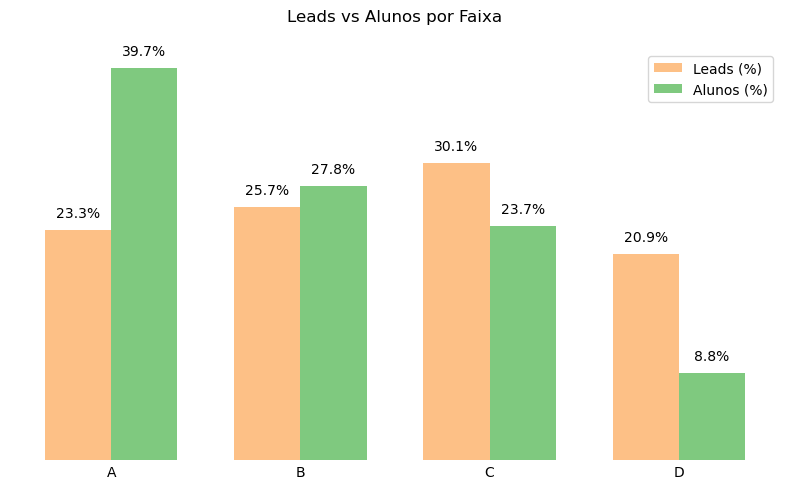

In [15]:
plot_comparativo_leads_alunos(df_leads, df_alunos)

In [16]:
# 1. Contagem por faixa
contagem = (
    df_leads.groupby(["lancamentos", "leadscore_faixa"], observed=True)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 2. Percentual por faixa
percentual = (
    contagem.div(contagem.sum(axis=1), axis=0).round(3) * 100
)
percentual = percentual.rename(columns={col: f"{col} (%)" for col in percentual.columns})

# 3. Média do leadscore final
media_score = (
    df_leads.groupby("lancamentos", observed=True)["leadscore_mapeado"]
    .mean()
    .round(2)
)
media_score.name = "leadscore_medio"

# 4. Combinar tudo
tabela_lancamentos = pd.concat([contagem, percentual, media_score], axis=1)

# 5. Organizar colunas em pares: A, A (%), B, B (%), ...
colunas = []
for faixa in ["A", "B", "C", "D"]:
    colunas.append(faixa)
    colunas.append(f"{faixa} (%)")
colunas.append("leadscore_medio")

tabela_lancamentos = tabela_lancamentos[colunas]

# 6. Exibir
display(tabela_lancamentos)


,A,A (%),B,B (%),C,C (%),D,D (%),leadscore_medio
lancamentos,,,,,,,,,
SSP-L12,6098,23.3,6741,25.7,7904,30.1,5484,20.9,349.39


In [17]:
# 1. Contagem por faixa
contagem = (
    df_alunos.groupby(["lancamentos", "leadscore_faixa"], observed=False)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 2. Percentual por faixa
percentual = (
    contagem.div(contagem.sum(axis=1), axis=0).round(3) * 100
)
percentual = percentual.rename(columns={col: f"{col} (%)" for col in percentual.columns})

# 3. Média do leadscore final
media_score = (
    df_leads.groupby("lancamentos", observed=True)["leadscore_mapeado"]
    .mean()
    .round(2)
)

media_score.name = "leadscore_medio"

# 4. Combinar tudo
tabela_lancamentos = pd.concat([contagem, percentual, media_score], axis=1)

# 5. Organizar colunas em pares: A, A (%), B, B (%), ...
colunas = []
for faixa in ["A", "B", "C", "D"]:
    colunas.append(faixa)
    colunas.append(f"{faixa} (%)")
colunas.append("leadscore_medio")

tabela_lancamentos = tabela_lancamentos[colunas]

# 6. Exibir
display(tabela_lancamentos)


,A,A (%),B,B (%),C,C (%),D,D (%),leadscore_medio
lancamentos,,,,,,,,,
SSP-L12,77,39.7,54,27.8,46,23.7,17,8.8,349.39


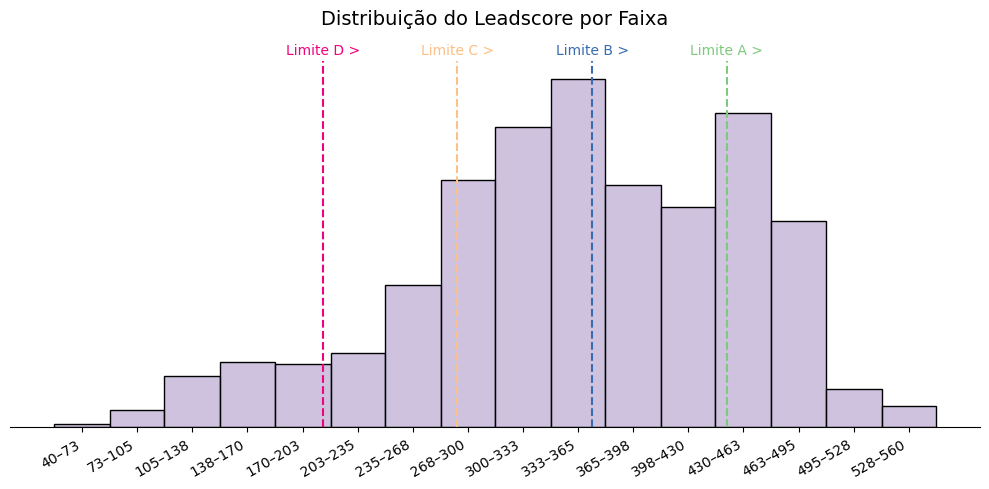

In [18]:
plot_histograma_leadscore(df_leads, limite_a, limite_b, limite_c, limite_d)

In [19]:
# Seleciona leads com faixa A ou B
leads_quentes = df_leads[df_leads["leadscore_faixa"].isin(["A", "B"])]
total_quentes = leads_quentes.shape[0]

# Quantos desses já compraram
compraram_quentes = leads_quentes["comprou"].sum()

# Resultado
print(f"Leads classificados como A ou B: {total_quentes}")
print(f"Desses, já compraram: {compraram_quentes}")
print(f"Ainda não compraram: {total_quentes - compraram_quentes}")

Leads classificados como A ou B: 12839
Desses, já compraram: 131
Ainda não compraram: 12708


In [20]:
"""
Esse bloco monta um modelo de classificação binária para prever a probabilidade de conversão de leads, com:

- Entrada: Perfil e respostas do lead
- Saída: Chance de virar aluno
- Algoritmo: Gradient Boosting
- Métrica usada: ROC AUC
"""

features_leads = [
    "renda",
    "escolaridade",
    "idade",
    "nível",
    "situação profissional"
]

# One-hot encoding
X = pd.get_dummies(df_leads[features_leads], drop_first=False)
y = df_leads["comprou"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Modelo
modelo_class = GradientBoostingClassifier(random_state=42)
modelo_class.fit(X_train, y_train)

# Avaliação
roc_auc = roc_auc_score(y_test, modelo_class.predict_proba(X_test)[:, 1])
print(f"ROC AUC (possível comprador): {roc_auc:.3f}")

# (Opcional) Score de probabilidade
df_leads["probabilidade_conversao_modelo"] = modelo_class.predict_proba(X)[:, 1]

ROC AUC (possível comprador): 0.692


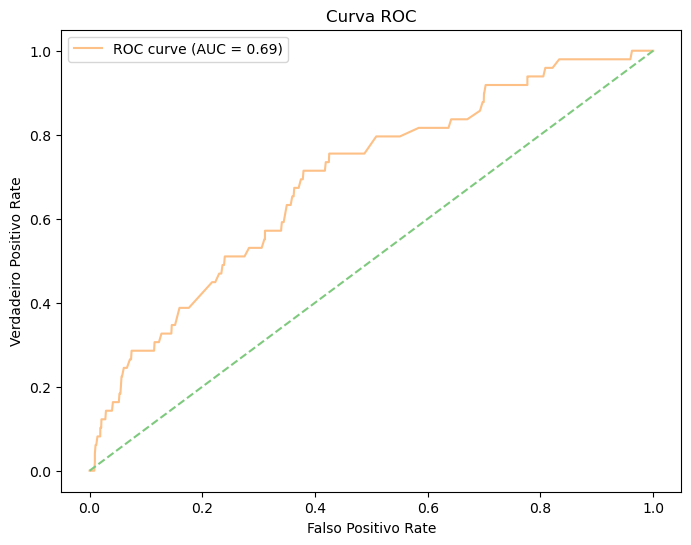

,Threshold,Precision,Recall,F1 Score
2,0.040816,0.042,0.061,0.050
1,0.020408,0.027,0.163,0.047
0,0.000000,0.007,1.000,0.015
48,0.979592,0.000,0.000,0.000
36,0.734694,0.000,0.000,0.000
27,0.551020,0.000,0.000,0.000
28,0.571429,0.000,0.000,0.000
29,0.591837,0.000,0.000,0.000
30,0.612245,0.000,0.000,0.000
31,0.632653,0.000,0.000,0.000


In [21]:
# Certifique-se de ter X_test, y_test e modelo treinado
probs = modelo_class.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Plotar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, probs):.2f})", color=cores[2])
plt.plot([0, 1], [0, 1], linestyle="--", color=cores[0])
plt.xlabel("Falso Positivo Rate")
plt.ylabel("Verdadeiro Positivo Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(False)
plt.show()

# Avaliação para thresholds de 0.0 até 1.0
thresholds_to_test = np.linspace(0, 1, 50)
metrics = []

for thresh in thresholds_to_test:
    y_pred = (probs >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    metrics.append((thresh, precision, recall, f1))

# Mostrar tabela de avaliação
df_thresholds = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1 Score"])
df_thresholds["F1 Score"] = df_thresholds["F1 Score"].round(3)
df_thresholds["Precision"] = df_thresholds["Precision"].round(3)
df_thresholds["Recall"] = df_thresholds["Recall"].round(3)
df_thresholds.sort_values("F1 Score", ascending=False).head(10)

In [22]:
"""
Você poderá usar esse modelo para prever o score mesmo para leads que não constam no score_map ou para variáveis novas.
Também ajuda a testar consistência entre o modelo treinado e o score heurístico que você aplicou com base nos lifts.
"""

# Preparo dos dados
X_reg = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
y_reg = df_alunos["leadscore_mapeado"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, random_state=42)

# Modelo de regressão
modelo_reg = GradientBoostingRegressor(random_state=42)
modelo_reg.fit(X_train_r, y_train_r)

# Avaliação
y_pred_r = modelo_reg.predict(X_test_r)
mae = mean_absolute_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)
mae_pct = (mae / y_test_r.mean()) * 100

print(f"R² (leadscore_mapeado): {r2:.2f}")
print(f"Erro médio absoluto (MAE): {mae:.2f}")
print(f"MAE percentual: {mae_pct:.2f}%")

R² (leadscore_mapeado): 0.98
Erro médio absoluto (MAE): 6.84
MAE percentual: 1.75%


In [23]:
# Previsão nos leads
X_leads = pd.get_dummies(df_leads[features_alunos], drop_first=False)
X_leads = X_leads.reindex(columns=X_reg.columns, fill_value=0)

# Gerar leadscore estimado contínuo
df_leads["leadscore_regressao"] = modelo_reg.predict(X_leads).round(2)

# Visualizar os top leads por score estimado
df_leads.head(10)

,data,email,idade,nível,situação profissional,renda,escolaridade,duvida,dificuldade,lancamentos,utm source,utm campaign,utm medium,utm content,comprou,leadscore_mapeado,leadscore_faixa,probabilidade_conversao_modelo,leadscore_regressao
0,2025-04-07 0:00:00,manoeltarsis22@gmail.com,33-37,Técnica,Autônomo,De 1.000 a 3.000,Ensino médio completo,O que preciso pra ser aprovado,Tempo,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | MIX DE PUBLICOS | CRIATIVO 07,ADS_007_ANUNCIO PETRO 07,0,347.58,C,0.004528,344.36
1,2025-04-07 0:00:00,geovanarodrigues0106@gmail.com,23-27,Técnica,Desempregado(a),Estou desempregado(a),Ensino superior incompleto,.,Separa material,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D,ADS_001_ANUNCIO PETRO 01,0,309.09,C,0.009411,308.33
2,2025-04-07 0:00:00,jj272824@gmail.com,18-22,Superior,Desempregado(a),Estou desempregado(a),Ensino médio completo,O quão difícil é conseguir passar,Nenhuma,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_006_ANUNCIO PETRO 06,0,129.08,D,0.001747,169.73
3,2025-04-07 0:00:00,iuriguerreiro45@gmail.com,28-32,Técnica,Desempregado(a),Estou desempregado(a),Nível técnico completo,Em qual lugar do Brasil pode fazer o concurso?,Tempo,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 30D,ADS_001_ANUNCIO PETRO 01,0,343.96,C,0.020366,341.09
4,2025-04-07 0:00:00,stevaogabrieli2020@gmail.com,18-22,Técnica,Autônomo,Estou desempregado(a),Ensino médio completo,Se precisa de ensino superior,Nenhuma,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | MIX DE PUBLICOS | CRIATIVO 08,ADS_008_ANUNCIO PETRO 08,0,277.58,D,0.004246,293.61
5,2025-04-07 0:00:00,sasilva123@gmail.com,46-52,Técnica,Desempregado(a),Estou desempregado(a),Ensino superior completo,Legislação,Memória,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | ABO | FRIO | ALL | BR | 0...,00 | AUTO | LAL | 1% | ENV 7D | CRIATIVO 10,ADS_010_ANUNCIO PETRO 10,0,389.45,B,0.018958,389.73
6,2025-04-07 0:00:00,romarioricardo27@gmail.com,33-37,Técnica,Funcionário de empresa privada,De 1.000 a 3.000,Ensino médio completo,Como vou conseguir?,Tempo,SSP-L12,Instagram,,Bio,,0,440.22,A,0.005067,444.93
7,2025-04-07 0:00:00,gabriel.nunes.2812@gmail.com,23-27,Técnica,Desempregado(a),Estou desempregado(a),Nível técnico completo,Sobre oque vai cair e se precisa de redação,Nenhuma,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_006_ANUNCIO PETRO 06,0,367.24,B,0.011721,353.10
8,2025-04-07 0:00:00,julianasp192001@gmail.com,23-27,Superior,Desempregado(a),De 0 a 1.000,Ensino superior incompleto,Como estudar,Concentração,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D,ADS_001_ANUNCIO PETRO 01,0,134.90,D,0.005638,134.27
9,2025-04-07 0:00:00,andersonae144@gmail.com,28-32,Técnica,Autônomo,De 1.000 a 3.000,Nível técnico completo,Mudança de vida,Tempo,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 14D,ADS_001_ANUNCIO PETRO 01,0,378.78,B,0.006655,363.90


In [24]:
df_leads.describe()

,comprou,leadscore_mapeado,probabilidade_conversao_modelo,leadscore_regressao
count,26227.000000,26227.000000,26227.000000,26227.000000
mean,0.007397,349.388277,0.007368,360.159688
std,0.085689,95.197654,0.010685,84.205996
min,0.000000,40.260000,0.000084,112.110000
25%,0.000000,287.940000,0.002941,310.890000
50%,0.000000,354.640000,0.005067,361.090000
75%,0.000000,429.280000,0.008576,435.100000
max,1.000000,560.210000,0.654250,550.830000


In [25]:
# Validar se o modelo de regressão estima bem as faixas reais dos alunos

# 1. Copiar info de score real e faixa real
df_avaliacao = df_alunos[["email", "leadscore_mapeado", "leadscore_faixa"]].copy()

# 2. Gerar os X para regressão (features iguais às usadas no modelo)
X_alunos = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
X_alunos = X_alunos.reindex(columns=X_reg.columns, fill_value=0)

# 3. Aplicar o modelo de regressão
df_avaliacao["leadscore_regressao"] = modelo_reg.predict(X_alunos)

# 4. Classificar usando a função baseada na média dos alunos
df_avaliacao["faixa_regressao"] = df_avaliacao["leadscore_regressao"].apply(classificar_faixa)

# 5. Ver a matriz de confusão real x predita
comparativo = df_avaliacao.groupby(["leadscore_faixa", "faixa_regressao"]).size().unstack(fill_value=0)

display(comparativo)

faixa_regressao,A,B,C,D
leadscore_faixa,,,,
A,74,3,0,0
B,4,50,0,0
C,0,3,42,1
D,0,0,0,17


In [26]:
# Juntar as bases
comparacao = df_leads.merge(
    df_alunos,
    on="email",
    suffixes=("_lead", "_aluno")
)

# Verificar onde as respostas foram diferentes
mudancas = {}
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    
    if col_lead in comparacao.columns and col_aluno in comparacao.columns:
        # Convertendo para string para evitar erro de comparação entre categoricals com categorias diferentes
        diferentes = (comparacao[col_lead].astype(str) != comparacao[col_aluno].astype(str)).sum()
        total = comparacao.shape[0]
        mudancas[var] = round((diferentes / total) * 100, 1)
    else:
        mudancas[var] = None  # Ou 0, ou continue

# Transformar em DataFrame para exibição
df_mudancas = pd.DataFrame.from_dict(mudancas, orient="index", columns=["% Respostas Diferentes"])
df_mudancas = df_mudancas.dropna().sort_values(by="% Respostas Diferentes", ascending=False)

df_mudancas

,% Respostas Diferentes
renda,0.0
escolaridade,0.0
idade,0.0
nível,0.0
situação profissional,0.0


In [27]:
# Para cada variável comum, mostrar diferenças
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    
    if col_lead in comparacao.columns and col_aluno in comparacao.columns:
        # Comparação como string para evitar erros com categorias
        diferentes = comparacao[comparacao[col_lead].astype(str) != comparacao[col_aluno].astype(str)]
        total = comparacao.shape[0]

        print(f"\n🔍 {len(diferentes)} de {total} respostas são diferentes em '{var}'")
        display(diferentes[["email", col_lead, col_aluno]].head(10))
    else:
        print(f"\n⚠️ Coluna '{var}' não encontrada em ambos os DataFrames.")


🔍 0 de 194 respostas são diferentes em 'renda'


,email,renda_lead,renda_aluno



🔍 0 de 194 respostas são diferentes em 'escolaridade'


,email,escolaridade_lead,escolaridade_aluno



🔍 0 de 194 respostas são diferentes em 'idade'


,email,idade_lead,idade_aluno



🔍 0 de 194 respostas são diferentes em 'nível'


,email,nível_lead,nível_aluno



🔍 0 de 194 respostas são diferentes em 'situação profissional'


,email,situação profissional_lead,situação profissional_aluno


In [28]:
"""
Esse modelo é o coração da previsão de probabilidade de conversão. E ele tem duas grandes vantagens:

1. Calibração com pesos → ajuda a lidar com o desbalanceamento real
2. Integração com o score → junta perfil sociodemográfico + quão parecido o lead é com os alunos
"""

# Preparar X e y
X = pd.get_dummies(df_leads[features_leads], drop_first=False)
X["leadscore_mapeado"] = df_leads["leadscore_mapeado"]  # Adiciona o score final como feature
y = df_leads["comprou"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

modelo_calibrado = GradientBoostingClassifier(random_state=42)
modelo_calibrado.fit(X_train, y_train, sample_weight=sample_weight)

# Score calibrado com base nas duas fontes
df_leads["probabilidade_conversao_modelo"] = modelo_calibrado.predict_proba(X)[:, 1]

# Avaliação
print("ROC AUC:", roc_auc_score(y_test, modelo_calibrado.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, modelo_calibrado.predict(X_test)))

ROC AUC: 0.6241768372991483
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      6508
           1       0.01      0.43      0.02        49

    accuracy                           0.74      6557
   macro avg       0.50      0.59      0.44      6557
weighted avg       0.99      0.74      0.85      6557



In [29]:
# Inicializar o scaler
scaler = MinMaxScaler()

# Normalizar os dois componentes separadamente
leadscore_normalizado = scaler.fit_transform(df_leads[["leadscore_regressao"]]).flatten()
probabilidade_normalizada = scaler.fit_transform(df_leads[["probabilidade_conversao_modelo"]]).flatten()

# Pesos (ajustáveis)
peso_score = 0.5
peso_prob = 0.5

# Calcular o score híbrido como média ponderada dos valores normalizados
df_leads["score_hibrido"] = (
    peso_score * leadscore_normalizado +
    peso_prob * probabilidade_normalizada
).round(4)

# Opcional: ordenar para inspeção
df_leads.head()

,data,email,idade,nível,situação profissional,renda,escolaridade,duvida,dificuldade,lancamentos,utm source,utm campaign,utm medium,utm content,comprou,leadscore_mapeado,leadscore_faixa,probabilidade_conversao_modelo,leadscore_regressao,score_hibrido
0,2025-04-07 0:00:00,manoeltarsis22@gmail.com,33-37,Técnica,Autônomo,De 1.000 a 3.000,Ensino médio completo,O que preciso pra ser aprovado,Tempo,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | MIX DE PUBLICOS | CRIATIVO 07,ADS_007_ANUNCIO PETRO 07,0,347.58,C,0.461972,344.36,0.5084
1,2025-04-07 0:00:00,geovanarodrigues0106@gmail.com,23-27,Técnica,Desempregado(a),Estou desempregado(a),Ensino superior incompleto,.,Separa material,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D,ADS_001_ANUNCIO PETRO 01,0,309.09,C,0.443896,308.33,0.4577
2,2025-04-07 0:00:00,jj272824@gmail.com,18-22,Superior,Desempregado(a),Estou desempregado(a),Ensino médio completo,O quão difícil é conseguir passar,Nenhuma,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_006_ANUNCIO PETRO 06,0,129.08,D,0.062995,169.73,0.0969
3,2025-04-07 0:00:00,iuriguerreiro45@gmail.com,28-32,Técnica,Desempregado(a),Estou desempregado(a),Nível técnico completo,Em qual lugar do Brasil pode fazer o concurso?,Tempo,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 30D,ADS_001_ANUNCIO PETRO 01,0,343.96,C,0.653333,341.09,0.6065
4,2025-04-07 0:00:00,stevaogabrieli2020@gmail.com,18-22,Técnica,Autônomo,Estou desempregado(a),Ensino médio completo,Se precisa de ensino superior,Nenhuma,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | MIX DE PUBLICOS | CRIATIVO 08,ADS_008_ANUNCIO PETRO 08,0,277.58,D,0.173024,293.61,0.2967


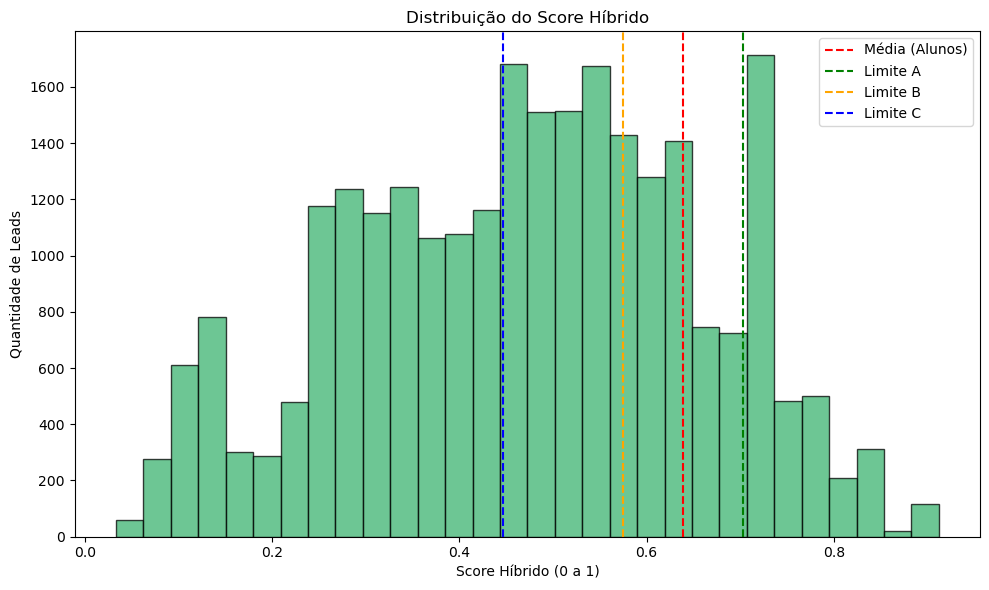

,Total Leads,Alunos,Taxa de Conversão (%)
faixa_score_hibrido,,,
A,3513,82,2.3%
B,4744,48,1.0%
C,6970,39,0.6%
D,11000,25,0.2%


In [30]:
# Base de referência: score_hibrido dos ALUNOS
media_hibrido_alunos = df_leads[df_leads["comprou"] == 1]["score_hibrido"].mean()

# Limiares baseados na média dos alunos
limite_A = media_hibrido_alunos * 1.10
limite_B = media_hibrido_alunos * 0.90
limite_C = media_hibrido_alunos * 0.70

# Função de classificação
def classificar_faixa_hibrida(score):
    if score >= limite_A:
        return "A"
    elif score >= limite_B:
        return "B"
    elif score >= limite_C:
        return "C"
    else:
        return "D"

# Aplicar a classificação
df_leads["faixa_score_hibrido"] = df_leads["score_hibrido"].apply(classificar_faixa_hibrida)

# Plotar histograma do score_hibrido
plt.figure(figsize=(10, 6))
plt.hist(df_leads["score_hibrido"], bins=30, color="mediumseagreen", edgecolor="black", alpha=0.75)
plt.axvline(media_hibrido_alunos, color="red", linestyle="--", label="Média (Alunos)")
plt.axvline(limite_A, color="green", linestyle="--", label="Limite A")
plt.axvline(limite_B, color="orange", linestyle="--", label="Limite B")
plt.axvline(limite_C, color="blue", linestyle="--", label="Limite C")

plt.title("Distribuição do Score Híbrido")
plt.xlabel("Score Híbrido (0 a 1)")
plt.ylabel("Quantidade de Leads")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Gerar tabela de faixas com base na nova coluna faixa_score_hibrido
tabela_faixas_hibrido = (
    df_leads
    .groupby("faixa_score_hibrido")["comprou"]
    .agg(["count", "sum", "mean"])
    .rename(columns={
        "count": "Total Leads", 
        "sum": "Alunos", 
        "mean": "Taxa de Conversão"
    })
    .sort_index()
    .round(4)
)

# Formatar a taxa de conversão como string percentual
tabela_faixas_hibrido["Taxa de Conversão (%)"] = (
    tabela_faixas_hibrido["Taxa de Conversão"] * 100
).round(1).astype(str) + "%"

# Opcional: remover coluna bruta
tabela_faixas_hibrido = tabela_faixas_hibrido.drop(columns="Taxa de Conversão")

# Exibir resultado
display(tabela_faixas_hibrido)

In [31]:
# Calcular média do score híbrido por lançamento
media_hibrido_por_lancamento = (
    df_leads.groupby("lancamentos", observed=True)["score_hibrido"]
    .mean()
    .round(2)
    .reset_index()
    .rename(columns={"score_hibrido": "Probabilidade Relativa (0 - 1)"})
)

display(media_hibrido_por_lancamento)

,lancamentos,Probabilidade Relativa (0 - 1)
0,SSP-L12,0.47


In [32]:
# Agrupamento por lançamento
tabela_lancamentos_avancada = df_leads.groupby("lancamentos", observed=True).agg(
    total_leads=("email", "count"),
    compras_reais=("comprou", "sum"),
    score_hibrido_medio=("score_hibrido", "mean"),
    probabilidade_media_modelo=("probabilidade_conversao_modelo", "mean"),
    taxa_real_conversao=("comprou", "mean")  # 0 = não comprou, 1 = comprou
).reset_index()

# Formatando colunas
tabela_lancamentos_avancada["score_hibrido_medio"] = tabela_lancamentos_avancada["score_hibrido_medio"].round(2)
tabela_lancamentos_avancada["probabilidade_media_modelo"] = (tabela_lancamentos_avancada["probabilidade_media_modelo"]).round(2)
tabela_lancamentos_avancada["taxa_real_conversao (%)"] = (tabela_lancamentos_avancada["taxa_real_conversao"] * 100).round(2)

# Selecionar colunas finais
tabela_lancamentos_avancada = tabela_lancamentos_avancada[[
    "lancamentos",
    "total_leads",
    "compras_reais",
    "taxa_real_conversao (%)",
    "probabilidade_media_modelo",
    "score_hibrido_medio"
]]

# Exibir resultado
display(tabela_lancamentos_avancada)

,lancamentos,total_leads,compras_reais,taxa_real_conversao (%),probabilidade_media_modelo,score_hibrido_medio
0,SSP-L12,26227,194,0.74,0.36,0.47


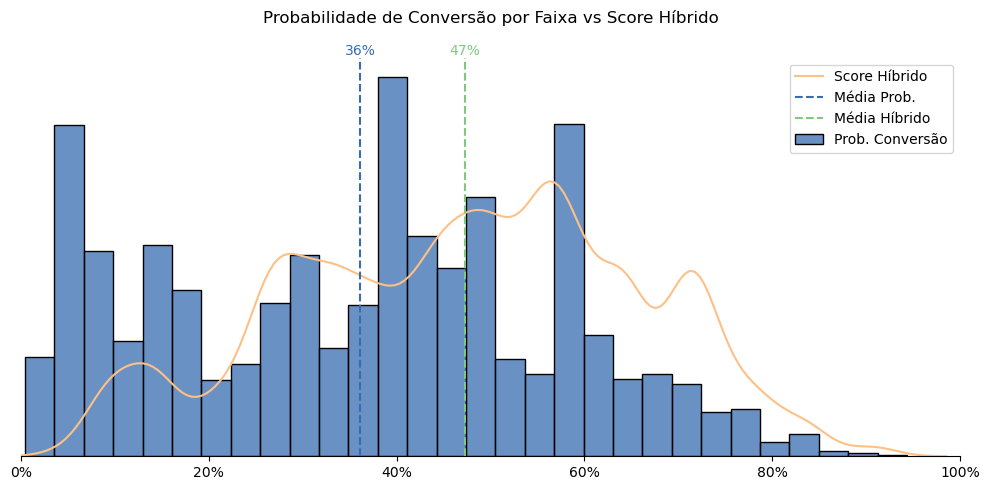

In [33]:
plot_probabilidade_conversao_vs_score(df_leads)

In [34]:
# Gerar a tabela cruzada real x predita com leads que viraram alunos
df_compare = df_leads[df_leads["email"].isin(df_alunos["email"])][["email", "faixa_score_hibrido"]]
df_compare = df_compare.merge(
    df_alunos[["email", "leadscore_faixa"]],
    on="email"
)

# Tabela cruzada: faixa real (aluno) vs faixa predita (modelo híbrido)
comparativo_faixa = pd.crosstab(df_compare["leadscore_faixa"], df_compare["faixa_score_hibrido"])

# Calcular Cramér’s V com essa matriz
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Calcular e imprimir
cramers_v_score = cramers_v(comparativo_faixa)
print(f"Cramér’s V: {cramers_v_score:.3f} (0 = sem associação, 1 = associação perfeita)")

Cramér’s V: 0.458 (0 = sem associação, 1 = associação perfeita)


In [35]:
# Caminho direto para a pasta 'modelos'
path_modelos = Path().resolve().parent / "modelos"

# Média dos compradores (referência para benchmarking)
media_compradores = df_alunos["leadscore_mapeado"].mean()

# 1. Modelo de regressão para prever leadscore
joblib.dump(modelo_reg, path_modelos / "modelo_regressao_leadscore_total.pkl")
joblib.dump(X_reg.columns.tolist(), path_modelos / "colunas_regressao.pkl")

# 2. Limites para classificar em faixas A, B, C, D
limites = {
    "media_compradores": media_compradores,
    "limite_a": limite_a,
    "limite_b": limite_b,
    "limite_c": limite_c,
    "limite_d": limite_d
}
joblib.dump(limites, path_modelos / "limites_faixa.pkl")

joblib.dump(score_map, path_modelos / "score_map.pkl")

# 3. Modelo de classificação calibrado para prever conversão
joblib.dump(modelo_calibrado, path_modelos / "modelo_conversao_calibrado.pkl")
joblib.dump(X.columns.tolist(), path_modelos / "colunas_modelo_conversao_calibrado.pkl")

tabelas_lift = {}
for feature in features_alunos:
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_leads[df_leads["comprou"] == 1], feature)
    tabelas_lift[feature] = tabela

# === Salvar tabelas_lift
joblib.dump(tabelas_lift, path_modelos / "tabelas_lift.pkl")

# 4. Confirmação
print("✅ Modelos e arquivos de configuração exportados para:", path_modelos)

✅ Modelos e arquivos de configuração exportados para: C:\Users\Camilo_Bica\data_science\consultoria\acelerador_petrobras\modelos


In [37]:
from gspread_dataframe import set_with_dataframe
from datetime import datetime

# Carrega as variáveis de ambiente
load_dotenv()

# Pega o caminho de forma segura
credenciais_path = os.getenv("GOOGLE_CREDENTIALS_PATH")

# === Escopos de acesso ===
scopes = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]

# === Autenticar ===
creds = service_account.Credentials.from_service_account_file(
    credenciais_path,
    scopes=scopes
)
client = gspread.authorize(creds)

# === Função para criar nova planilha e carregar dados ===
def criar_planilha_e_enviar(df, nome_base):
    nome_final = nome_base
    
    # Cria nova planilha
    planilha = client.create(nome_final)
    
    # Compartilha com seu e-mail pessoal (aqui você coloca o seu)
    planilha.share('camilobf2@gmail.com', perm_type='user', role='writer')  # <<< Trocar pelo seu email do Gmail

    # Preenche a primeira aba
    aba = planilha.sheet1
    aba.update_title("Dados")
    set_with_dataframe(aba, df)
    
    print(f"✅ Nova planilha criada: {nome_final}")
    print(f"🔗 Link: https://docs.google.com/spreadsheets/d/{planilha.id}/edit")

# === Geração dos arquivos ===
#criar_planilha_e_enviar(df_leads, "leadscore_implementado")

✅ Nova planilha criada: leadscore_implementado
🔗 Link: https://docs.google.com/spreadsheets/d/1otpSf30y2iqykxNNiCmN3DjxVDTuHSVZhOpzwi8UBBc/edit


In [38]:
# === Função para atualizar uma planilha existente ===
def atualizar_planilha_existente(df: pd.DataFrame, sheet_id: str, aba_nome: str = "Dados"):
    """
    Atualiza uma aba específica de uma planilha no Google Sheets.
    
    - df: DataFrame com os dados que serão enviados
    - sheet_id: ID da planilha (o que vem na URL depois de "/d/")
    - aba_nome: Nome da aba que será atualizada (default: 'Dados')
    """
    try:
        planilha = client.open_by_key(sheet_id)
        try:
            aba = planilha.worksheet(aba_nome)
        except gspread.WorksheetNotFound:
            aba = planilha.add_worksheet(title=aba_nome, rows="1000", cols="20")
        
        aba.clear()  # Limpa dados antigos
        set_with_dataframe(aba, df)
        
        print(f"✅ Planilha atualizada: https://docs.google.com/spreadsheets/d/{sheet_id}/edit")
    except Exception as e:
        print(f"❌ Erro ao atualizar a planilha: {e}")

# === IDs das planilhas (FIXOS, preencha certinho aqui) ===
id_leads = "1otpSf30y2iqykxNNiCmN3DjxVDTuHSVZhOpzwi8UBBc"


# === Atualizar todas as planilhas ===
atualizar_planilha_existente(df_leads, id_leads)

✅ Planilha atualizada: https://docs.google.com/spreadsheets/d/1otpSf30y2iqykxNNiCmN3DjxVDTuHSVZhOpzwi8UBBc/edit
